<h2><center>Critical Temperature Prediction 1</center></h2>

<h3><center>Decision Trees, Linear Regression, Logistic Regression</center></h3>

---

The purpose of this project is to produce the best possible regression and binary classification models using decision trees and linear models on a chemical dataset. The latter contains information on 21174 superconductors and 81 chemical features along with the critical temperature, which constitutes the target variable and was adapted from the [supercondutivity data](https://archive.ics.uci.edu/dataset/464/superconductivty+data).

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, ConfusionMatrixDisplay 
from sklearn.metrics import explained_variance_score, root_mean_squared_error, max_error, mean_absolute_error
from scipy.stats import pearsonr
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from statsmodels.api import OLS, add_constant

## Exploratory Data Analysis and Data Pre-Processing

In [2]:
data = pd.read_csv("scaled_dataset.tsv", sep="\t")

In [3]:
data

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,-2.1737,-2.5469,-1.8316,-1.9110,-1.2742,-3.2043,-2.6712,-2.1218,-1.2523,-2.2206,...,0.7124,0.9014,0.8055,-3.3123,-2.7858,-1.6406,-1.5235,-1.7297,-1.4782,52.000
1,-2.1737,-2.5469,-1.8316,-1.9110,-1.2742,-3.2043,-2.6712,-2.1218,-1.2523,-2.2206,...,0.7124,0.9014,0.8055,-3.3123,-2.7858,-1.6406,-1.5235,-1.7297,-1.4782,50.000
2,-2.1737,-2.5469,-1.8316,-1.9110,-1.2742,-3.2043,-2.6712,-2.1218,-1.2523,-2.2206,...,0.7124,0.9014,0.8055,-3.3123,-2.7858,-1.6406,-1.5235,-1.7297,-1.4782,41.500
3,-2.1737,-2.5469,-1.8316,-1.9110,-1.2742,-3.2043,-2.6712,-2.1218,-1.2523,-2.2206,...,0.7124,0.9014,0.8055,-3.3123,-2.7858,-1.6406,-1.5235,-1.7297,-1.4782,32.000
4,-2.1737,-1.5994,-0.9850,-1.0041,-0.5006,-3.2043,-2.6712,-2.1218,-1.2523,-2.2206,...,-0.9684,-1.0090,-0.8995,-3.3123,-2.7858,-1.6406,-1.5235,-1.7297,-1.4782,29.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21169,-1.4777,-1.5696,-1.3792,-1.0551,-0.8610,-1.4650,-2.6345,-1.6094,-0.2289,-1.5220,...,-0.1272,0.3895,-0.0463,-1.5698,-2.7590,-0.8366,1.5587,-0.6981,-1.4088,0.596
21170,-1.4777,-1.5696,-1.3794,-1.0551,-0.8612,-1.4650,-2.6426,-1.6094,-0.2281,-1.5220,...,-0.1274,0.3895,-0.0465,-1.5698,-2.7649,-0.8366,1.5605,-0.6981,-1.4181,0.700
21171,0.6104,-1.2091,-0.3571,-0.8493,-0.0501,0.8948,-0.0899,-0.8092,0.1210,-1.0294,...,-0.8538,-0.6248,-0.8270,0.5646,0.6106,0.7715,-0.4937,0.7460,-0.1070,73.000
21172,-1.4777,2.3104,3.2518,2.5600,3.2684,-1.3983,-1.7172,-0.6162,3.8693,-0.1679,...,1.2167,0.7801,1.2440,-1.6243,-1.7637,-0.0325,1.9778,0.3334,0.2772,0.280


In [4]:
data.shape

(21174, 82)

In [5]:
data.isnull().sum().sum()

0

In [6]:
x_data = data.drop(columns = ['critical_temp'])
y_data = data['critical_temp']
x_array = np.array(x_data)
y_array = np.array(y_data)
y_class = np.array([int(i > 80.0) for i in y_data])
vals, counts= np.unique(y_class, return_counts=True)
for v, c in zip(vals, counts):
    print(v, "--->", c)

0 ---> 17768
1 ---> 3406


## Objective 1 - Best Regression Model

To produce the best regression model for the target variable, two machine learning algorithms were used, namely decision trees and linear regression (with and without regularization).  

In [7]:
x_train, x_ivs, y_train, y_ivs = train_test_split(x_array, y_array, test_size=0.25, random_state=1337)

In [8]:
def perform_k_fold(model, x_data, y_data, n_splits=5):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=23)
    truth_nfold = None
    preds_nfold = None
    
    for result in kf.split(x_data):
        train_index = result[0]
        test_index = result[1]
        x_train, x_test = x_data[train_index], x_data[test_index]
        y_train, y_test = y_data[train_index], y_data[test_index]
        model.fit(x_train, y_train)
        preds = model.predict(x_test)

        if truth_nfold is None:
            preds_nfold = preds
            truth_nfold = y_test
        else:
            preds_nfold = np.hstack((preds_nfold, preds))
            truth_nfold = np.hstack((truth_nfold, y_test))
    
    return truth_nfold, preds_nfold

In [9]:
def print_regression_statistics(truth, preds):
    
    print("The RVE is: ", explained_variance_score(truth, preds))
    print("The rmse is: ", root_mean_squared_error(truth, preds))
    corr, pval = pearsonr(truth, preds)
    print("The Correlation Score is is: %6.4f (p-value=%e)"%(corr,pval))
    print("The Maximum Error is is: ", max_error(truth, preds))
    print("The Mean Absolute Error is: ", mean_absolute_error(truth, preds))

### Decision Tree Regressor

In [10]:
results_dtr = {"splitter": [], "max_depth": [], "min_samples_leaf": [], "rmse": []}
for s in ["best", "random"]:
    for md in range(1,11):
        for msl in range(1,26,2):
            decision_tree_regressor = tree.DecisionTreeRegressor(splitter=s, max_depth=md, min_samples_leaf=msl)
            truth, preds = perform_k_fold(decision_tree_regressor, x_train, y_train, n_splits=5)
            results_dtr["splitter"].append(s)
            results_dtr["max_depth"].append(md)
            results_dtr["min_samples_leaf"].append(msl)
            results_dtr["rmse"].append(root_mean_squared_error(truth, preds))

In [11]:
df_results_dtr = pd.DataFrame(results_dtr)
lowest_rmse_index = df_results_dtr['rmse'].idxmin()
lowest_rmse_values = df_results_dtr.loc[lowest_rmse_index, ['splitter', 'max_depth', 'min_samples_leaf']]
print("The decision tree regressor with the lowest rmse has the following parameters:")
print(f"splitter: {lowest_rmse_values['splitter']}, max_depth: {lowest_rmse_values['max_depth']}, min_samples_leaf: {lowest_rmse_values['min_samples_leaf']}")

The decision tree regressor with the lowest rmse has the following parameters:
splitter: best, max_depth: 10, min_samples_leaf: 7


In [12]:
decision_tree_regressor = tree.DecisionTreeRegressor(splitter='best', min_samples_leaf=5, max_depth=10)
truth, preds = perform_k_fold(decision_tree_regressor, x_train, y_train)
print('Statistics for Decision Tree Regressor in the training set:')
print_regression_statistics(truth, preds)

Statistics for Decision Tree Regressor in the training set:
The RVE is:  0.8571841462961323
The rmse is:  12.996441196432515
The Correlation Score is is: 0.9261 (p-value=0.000000e+00)
The Maximum Error is is:  178.02
The Mean Absolute Error is:  7.853919433118327


### Linear Regression

#### Using statsmodel

In [13]:
x_train_with_intercept = add_constant(x_train)
model = OLS(y_train, x_train_with_intercept, hasconst=12).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     549.4
Date:                Tue, 27 May 2025   Prob (F-statistic):               0.00
Time:                        17:10:42   Log-Likelihood:                -68078.
No. Observations:               15880   AIC:                         1.363e+05
Df Residuals:                   15798   BIC:                         1.369e+05
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.4725      0.140    246.010      0.0

#### Using scikit-learn with variable selection

In [14]:
columns_to_remove = [6, 8, 12, 20, 32, 38, 41, 66, 70, 78]
x_train_variable_selection = np.delete(x_train, columns_to_remove, axis=1)

In [15]:
linear_regression_model = LinearRegression()
truth, preds = perform_k_fold(linear_regression_model, x_train_variable_selection, y_train)
print('Statistics for Linear Regression in the training set:')
print_regression_statistics(truth, preds)

Statistics for Linear Regression in the training set:
The RVE is:  0.7351808574197878
The rmse is:  17.697412702800175
The Correlation Score is is: 0.8574 (p-value=0.000000e+00)
The Maximum Error is is:  181.29589744182462
The Mean Absolute Error is:  13.39690496049625


### Linear Regularized Models

In [16]:
def plot_param_search_results(model_name, rmse_train, rmse_test, alphas):
    
    plt.figure(figsize=(5, 3))
    plt.title("Alphas for: %s" % model_name)
    plt.plot(alphas, rmse_train, label="rmse Train")
    plt.plot(alphas, rmse_test, label="rmse Test")
    plt.grid()
    plt.legend()
    plt.show()

In [17]:
alphas = 2**np.arange(0, -10, -.5)
kf = KFold(n_splits=5, shuffle=True, random_state=23)

In [18]:
def param_search_rlms(rlms=[Ridge, Lasso, ElasticNet], alphas=alphas):
    
    results = []

    for m in rlms:
        rmse_train = []
        rmse_test = []
        min_rmse_test = float('inf')
        min_rmse_train = float('inf')

        for alpha in alphas:
            truth_train_nfold = None
            truth_test_nfold = None
            preds_train_nfold = None
            preds_test_nfold = None

            for train_index, test_index in kf.split(x_train):
                x_fold_train, x_fold_test = x_train[train_index], x_train[test_index]
                y_fold_train, y_fold_test = y_train[train_index], y_train[test_index]
                M = m(alpha=alpha, max_iter=100000).fit(x_fold_train, y_fold_train)
                preds_tr = M.predict(x_fold_train)
                preds_te = M.predict(x_fold_test)

                if truth_train_nfold is None:            
                    preds_train_nfold = preds_tr
                    preds_test_nfold = preds_te
                    truth_train_nfold = y_fold_train
                    truth_test_nfold = y_fold_test
                else:
                    preds_train_nfold = np.hstack((preds_train_nfold, preds_tr))
                    preds_test_nfold = np.hstack((preds_test_nfold, preds_te))
                    truth_train_nfold = np.hstack((truth_train_nfold, y_fold_train))
                    truth_test_nfold = np.hstack((truth_test_nfold, y_fold_test))
            
            current_rmse_train = root_mean_squared_error(truth_train_nfold, preds_train_nfold)
            current_rmse_test = root_mean_squared_error(truth_test_nfold, preds_test_nfold)
            rmse_train.append(current_rmse_train)
            rmse_test.append(current_rmse_test)
            min_alpha_rmse_train = (alpha, current_rmse_train if current_rmse_train < min_rmse_train else min_rmse_train)
            min_alpha_rmse_test = (alpha, current_rmse_test if current_rmse_test < min_rmse_test else min_rmse_test)
        
        (min_alpha_train, min_rmse_train) = min_alpha_rmse_train
        (min_alpha_test, min_rmse_test) = min_alpha_rmse_test
        
        model_name = m().__class__.__name__
        print("Model: ", m().__class__.__name__)
        print("Minimum rmse train is: %s at alpha %s" %(min_rmse_train, min_alpha_train))
        print("Minimum rmse test is: %s at alpha %s" %(min_rmse_test, min_alpha_test))
        results.append({"model": m,
                        "model_name": model_name,
                        "rmse_train": rmse_train,
                        "rmse_test": rmse_test,
                        "best_alpha": min_alpha_test})
        
        plot_param_search_results(model_name, rmse_train, rmse_test, alphas)
        
    return results

Model:  Ridge
Minimum rmse train is: 17.594542807353633 at alpha 0.0013810679320049757
Minimum rmse test is: 17.677930727420012 at alpha 0.0013810679320049757


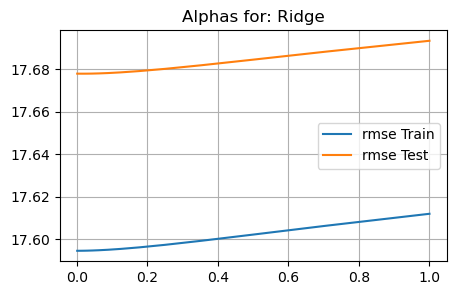

Model:  Lasso
Minimum rmse train is: 17.60450468648651 at alpha 0.0013810679320049757
Minimum rmse test is: 17.686124018207277 at alpha 0.0013810679320049757


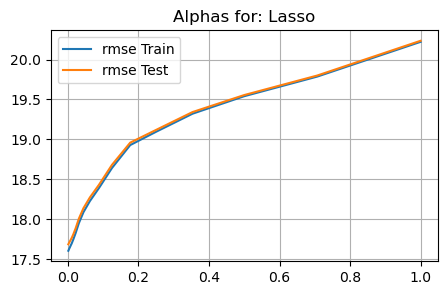

Model:  ElasticNet
Minimum rmse train is: 17.69567796391386 at alpha 0.0013810679320049757
Minimum rmse test is: 17.767605561893156 at alpha 0.0013810679320049757


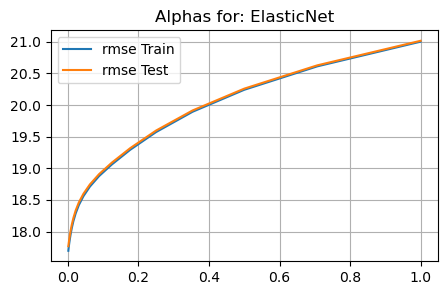

In [19]:
results = param_search_rlms()

In [20]:
alphas = 2**np.arange(2, -10, -.5)

In [21]:
def compute_coefficients_alphas(model, x_data, y_data, alphas):

    coefs = []
    for alpha in alphas:
        mdl = model(alpha=alpha, max_iter=100000).fit(x_data, y_data)
        coefs.append(mdl.coef_)
    coefs = np.array(coefs)

    return coefs

In [22]:
def plot_coefficients_alphas(x_data, alphas, coefs, best_alpha):
    
    N,M = x_data.shape
    plt.figure(figsize=(9,6))
    for i in range(M):
        plt.plot(alphas, coefs[:,i], label="Var %d" % (i+1))
        
    plt.axvline(x = best_alpha, color='b', label='best Alpha')
    plt.xscale("log")
    plt.legend(fontsize='small', ncol=5, loc='center left', bbox_to_anchor=(1,0.5))
    plt.grid()
    plt.xlabel("Alpha")
    plt.ylabel("Coefficient Value")
    plt.show()

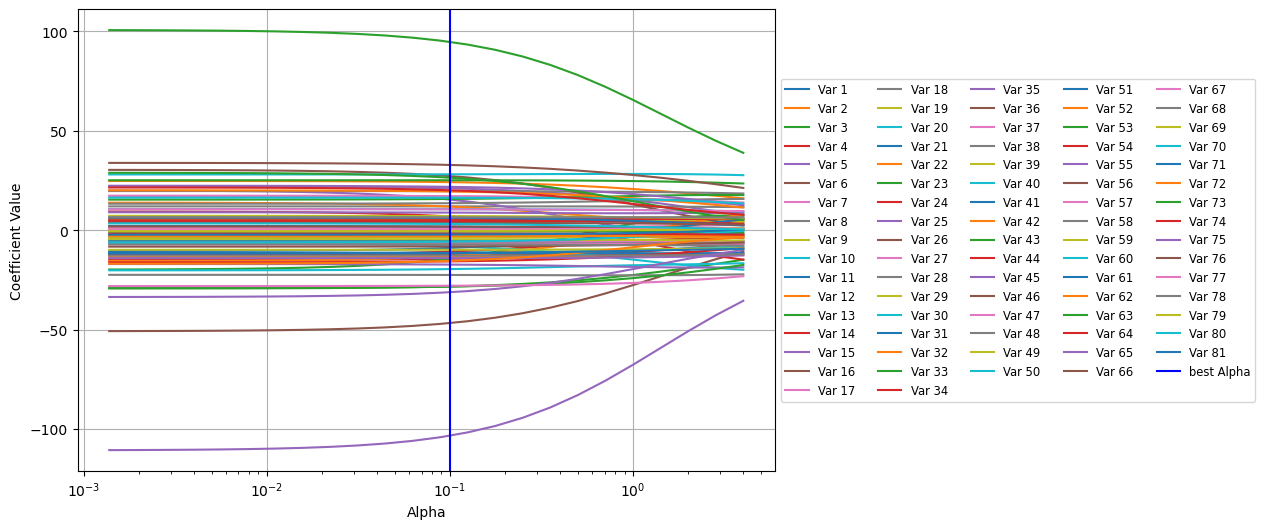

In [23]:
coefs_ridge = compute_coefficients_alphas(Ridge, x_train, y_train, alphas)
best_alpha = 0.1
plot_coefficients_alphas(x_train, alphas, coefs_ridge, best_alpha)

In [24]:
ridge_regression = Ridge(alpha=best_alpha, max_iter=9999999)
truth, preds = perform_k_fold(ridge_regression, x_train, y_train)
print('Statistics for Ridge Regression in the training set:')
print_regression_statistics(truth, preds)

Statistics for Ridge Regression in the training set:
The RVE is:  0.7357526439695526
The rmse is:  17.678297703052056
The Correlation Score is is: 0.8578 (p-value=0.000000e+00)
The Maximum Error is is:  178.87480839562744
The Mean Absolute Error is:  13.376850154373058


For the regression task of predicting the critical temperature of superconductors based on a set of 81 predictor variables, the performance of decision trees and linear models was reasonably high. Overall, decision trees displayed significantly better performance than linear regression models.

### Validating the selected regression model with the independent validation set data

In [25]:
best_regression_model = tree.DecisionTreeRegressor(splitter='best', max_depth = 10, min_samples_leaf=5)
best_regression_model.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=5)

In [26]:
ivs_preds_regressor = best_regression_model.predict(x_ivs)
print("Statistics for Decision Tree Regressor in the IVS:")
print_regression_statistics(y_ivs, ivs_preds_regressor)

Statistics for Decision Tree Regressor in the IVS:
The RVE is:  0.8699546349147987
The rmse is:  12.20729409235495
The Correlation Score is is: 0.9331 (p-value=0.000000e+00)
The Maximum Error is is:  113.19362068965518
The Mean Absolute Error is:  7.290375760641785


## Objective 2 - Best Binary Classification Model

To produce the best binary classification model for the target variable, the latter was first discretized into two classes, 0 (negative) and 1 (positive), with the first containing all instances where the temperature is below 80.0 and the second encompassing those with values equal or greater than 80.0. Subsequently, two machine learning algorithms were used for binary classification, namely decision trees and logistic regression.

In [27]:
x_train_c, x_ivs_c, y_train_c, y_ivs_c = train_test_split(x_array, y_class, test_size=0.25, random_state=1337)

In [28]:
def print_classification_statistics(truth, preds):
    
    print("The F1 score is: %7.4f" % f1_score(truth, preds, average = "macro"))
    print("The MCC score is: %7.4f" % matthews_corrcoef(truth, preds))
    print("The precision score is: %7.4f" % precision_score(truth, preds, average = "macro"))
    print("The recall score is: %7.4f" % recall_score(truth, preds, average = "macro"))
    print("The accuracy is: ", accuracy_score(truth, preds))

### Decision Tree Classifier

In [29]:
results_dtc = {"criterion": [], "splitter": [], "max_depth": [],  "min_samples_leaf": [], "MCC": []}
for c in ['gini', 'entropy']:
    for s in ['best', 'random']:
        for md in range(1,11):
            for msl in range(1,26,2):
                decision_tree_classifier = DecisionTreeClassifier(criterion=c, splitter=s, max_depth=md, min_samples_leaf=msl)
                truth, preds = perform_k_fold(decision_tree_classifier, x_train_c, y_train_c, n_splits=5)
                results_dtc["criterion"].append(c)
                results_dtc["splitter"].append(s)
                results_dtc["min_samples_leaf"].append(msl)
                results_dtc["max_depth"].append(md)
                results_dtc["MCC"].append(matthews_corrcoef(truth, preds))

In [30]:
df_results_dtc = pd.DataFrame(results_dtc)
highest_mcc_index = df_results_dtc['MCC'].idxmax()
highest_mcc_value = df_results_dtc.loc[highest_mcc_index, ['criterion','splitter', 'max_depth', 'min_samples_leaf']]
print("The decision tree classifier with the highest MCC has the following parameters:")
print(f"criterion: {highest_mcc_value['criterion']}, splitter: {highest_mcc_value['splitter']}, max_depth: {highest_mcc_value['max_depth']}, min_samples_leaf: {highest_mcc_value['min_samples_leaf']}")

The decision tree classifier with the highest MCC has the following parameters:
criterion: gini, splitter: best, max_depth: 10, min_samples_leaf: 1


In [31]:
decision_tree_classifier = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=10, min_samples_leaf=1)
truth, preds = perform_k_fold(decision_tree_classifier, x_train_c, y_train_c)
print('Statistics for Decision Tree Classifier in the training set:')
print_classification_statistics(truth, preds)

Statistics for Decision Tree Classifier in the training set:
The F1 score is:  0.8598
The MCC score is:  0.7197
The precision score is:  0.8574
The recall score is:  0.8623
The accuracy is:  0.9236146095717884


### Logistic Regression

In [32]:
logistic_regression_model = LogisticRegression(max_iter = 100000)
truth, preds = perform_k_fold(logistic_regression_model, x_train_c, y_train_c)
print('Statistics for Logistic Regresssion in the training set:')
print_classification_statistics(truth, preds)

Statistics for Logistic Regresssion in the training set:
The F1 score is:  0.7920
The MCC score is:  0.5855
The precision score is:  0.8066
The recall score is:  0.7796
The accuracy is:  0.8923173803526449


For the binary classification task of predicting negative and positive instances of superconductors based on a set of 81 predictor variables, the performance of decisions trees and logistic regression was reasonably good. Overall, decision trees displayed 
significantly better performance than logistic regression.

### Validating the selected binary classification model with the independent validation set data

In [33]:
best_classifier_model = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth = 10, min_samples_leaf=1)
best_classifier_model.fit(x_train_c, y_train_c)

DecisionTreeClassifier(max_depth=10)

In [34]:
ivs_preds_classifier = best_classifier_model.predict(x_ivs)

In [35]:
print("Statistics for Decision Tree Classifier in the IVS:")
print_classification_statistics(y_ivs_c, ivs_preds_classifier)

Statistics for Decision Tree Classifier in the IVS:
The F1 score is:  0.8745
The MCC score is:  0.7496
The precision score is:  0.8658
The recall score is:  0.8841
The accuracy is:  0.9310540234227427


This is the Confusion Matrix:


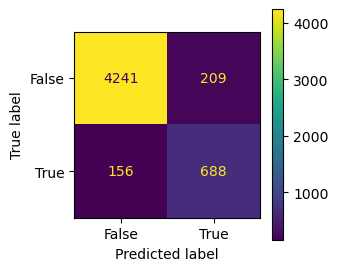

In [36]:
print('This is the Confusion Matrix:')
fig, ax = plt.subplots(figsize=(3, 3))
cmp = ConfusionMatrixDisplay.from_predictions(y_ivs_c, ivs_preds_classifier, ax = ax, display_labels = [False, True])